In [2]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

DESCRIPTIVES

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

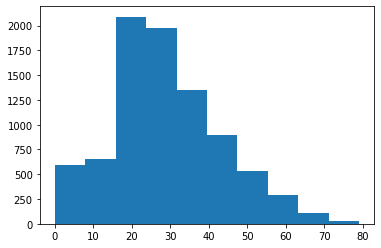

In [5]:
plt.hist(df_train.Age)

In [6]:
for column in df_train.columns[1:]:
    values = df_train[column].value_counts()
    if len(values) < 5:
        print(column, dict(values))
    else:
        print(f'{column} has {len(values)} different values')

HomePlanet {'Earth': 4602, 'Europa': 2131, 'Mars': 1759}
CryoSleep {False: 5439, True: 3037}
Cabin has 6560 different values
Destination {'TRAPPIST-1e': 5915, '55 Cancri e': 1800, 'PSO J318.5-22': 796}
Age has 80 different values
VIP {False: 8291, True: 199}
RoomService has 1273 different values
FoodCourt has 1507 different values
ShoppingMall has 1115 different values
Spa has 1327 different values
VRDeck has 1306 different values
Name has 8473 different values
Transported {True: 4378, False: 4315}


PREPROCESSING

In [7]:
def fillna_with_mode(df):
    for column in df.columns:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
        
    return df

def replace_with_numbers(df, column_names):
    for column in column_names:
        unique_values = sorted(df[column].unique())
        value_to_number = {value: i for i, value in enumerate(unique_values)}
        df[column] = df[column].replace(value_to_number)
    
    return df

def get_non_numeric_columns(df):
    non_numeric_columns = []
    
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]) or pd.api.types.is_bool_dtype(df[column]):
            non_numeric_columns.append(column)

    return non_numeric_columns

In [8]:
non_numeric_columns = get_non_numeric_columns(df_train)
del non_numeric_columns[-2]
non_numeric_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Transported']

In [9]:
df_test = fillna_with_mode(df_test)
df_train = fillna_with_mode(df_train)

df_test = replace_with_numbers(df_test, non_numeric_columns[:-1])
df_train = replace_with_numbers(df_train, non_numeric_columns)

In [10]:
df_train[:5]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,1,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,4,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [11]:
X = df_train[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
y = df_train['Transported']

SHALOW PREDICTIONS

In [16]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf_SVC = SVC(C=100)
cvs = cross_val_score(clf_SVC, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7886789955736899, 0.006791335205124823)

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=8)
cvs = cross_val_score(clf_RF, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7974221656957989, 0.010065651271644499)

DEEP PREDICTIONS

In [498]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X.to_numpy()).float(), 
                                                    torch.tensor(y.values).float(),
                                                    test_size=0.2, random_state=42)

In [499]:
from torch import nn

class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(11, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x.flatten()

In [500]:
torch.manual_seed(42)

model = BinaryClassificationModel()

list(model.parameters())

[Parameter containing:
 tensor([[ 0.2305,  0.2503, -0.0706,  0.2770, -0.0661,  0.0608, -0.1468,  0.1771,
           0.2658, -0.2212,  0.2621],
         [ 0.0564,  0.2228,  0.0408,  0.1454, -0.0426,  0.2324,  0.0446, -0.1408,
           0.0769, -0.1389, -0.0354],
         [-0.1225,  0.2000, -0.2380, -0.1390, -0.0851, -0.1813,  0.0285, -0.2978,
           0.2723, -0.2561,  0.2328],
         [ 0.0502, -0.0979,  0.1863,  0.0470,  0.2436,  0.0330, -0.0951,  0.0810,
          -0.0818,  0.1269,  0.2692],
         [ 0.1743, -0.1318,  0.1741,  0.0539,  0.1531, -0.1838, -0.2985, -0.1165,
          -0.2313,  0.2474,  0.0868],
         [ 0.1249,  0.0954, -0.0052,  0.2360, -0.2142,  0.0190, -0.2058,  0.0930,
          -0.1038,  0.0924, -0.0628],
         [ 0.2501, -0.1787, -0.1798, -0.1798,  0.2712,  0.1005,  0.2901, -0.2488,
          -0.2991, -0.2359, -0.2028],
         [ 0.1221,  0.1080,  0.2505, -0.1557, -0.2055,  0.1600, -0.1219,  0.1830,
          -0.0715,  0.1725, -0.2343],
         [-0.1522

In [501]:
with torch.inference_mode():
    random_prediction = model(X_test)

random_prediction[:5], y_test[:5]

(tensor([0., 1., 0., 0., 0.]), tensor([1., 0., 0., 1., 1.]))

In [502]:
from sklearn.metrics import accuracy_score

def get_accuracy_score(tensor_1, tensor_2):
    list_1 = [1 if item > 0.5 else int(item) for item in tensor_1]
    list_2 = [int(item) for item in tensor_2]

    return accuracy_score(list_1, list_2)

In [503]:
get_accuracy_score(random_prediction, y_test)

0.45543415756181715

In [504]:
def visualize_training(epoch_count, loss_values, test_loss_values):
    plt.plot(epoch_count, torch.tensor(loss_values).numpy(), label='Train loss')
    plt.plot(epoch_count, test_loss_values, label='Test loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

In [505]:
def model_train(model, X_train, y_train, visualize=False):
    torch.manual_seed(42)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 400

    epoch_count = []
    loss_values = []
    test_loss_values = []

    for epoch in range(epochs):
        
        if epoch == 250:
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


        model.train() # Sets parameters that require gradience to require gradient

        # Forward pass
        y_pred = model(X_train)

        # Calculate loss
        loss = loss_fn(y_pred, y_train)
        
        optimizer.zero_grad()

        # Perform backpropagation on the loss with respect to parameters
        loss.backward() # Start fresh each iteration

        # Step the optimizer (perform gradient descend)
        optimizer.step() # By default will accumulate through the loop, so zero them above

        with torch.inference_mode():
            test_pred = model(X_test)
            test_loss = loss_fn(test_pred, y_test)

        if epoch % 100 == 0:
            print(f'Epoch {epoch} | Loss: {test_loss}')
            epoch_count.append(epoch)
            loss_values.append(loss)
            test_loss_values.append(test_loss)


    model.eval() # Turns off gradient tracking
    if visualize:
        visualize_training(epoch_count, loss_values, test_loss_values)

Epoch 0 | Loss: 42.222469329833984
Epoch 100 | Loss: 20.336387634277344
Epoch 200 | Loss: 0.7815895080566406
Epoch 300 | Loss: 0.6263114213943481


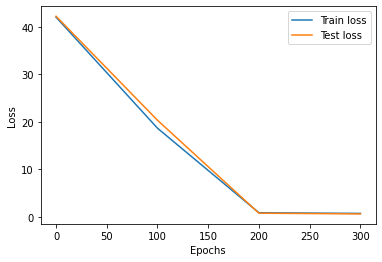

In [506]:
model_train(model, X_train, y_train, visualize=True)

In [507]:
with torch.inference_mode():
    training_prediction = model(X_test)

get_accuracy_score(training_prediction, y_test)

0.7550316273720529

In [512]:
overall_acc = []
for train, test in kfold.split(X_train, y_train):

    model = BinaryClassificationModel()
    model_train(model, X_train[train], y_train[train])
    predictions = model(X_train[test])
    acc = get_accuracy_score(predictions, y_train[test])
    print(f"Accuracy: {acc}")
    overall_acc.append(acc)

Epoch 0 | Loss: 45.168331146240234
Epoch 100 | Loss: 3.9973959922790527
Epoch 200 | Loss: 0.7278192043304443
Epoch 300 | Loss: 0.7486602663993835
Accuracy: 0.7713874910136592
Epoch 0 | Loss: 44.86315155029297
Epoch 100 | Loss: 6.321168899536133
Epoch 200 | Loss: 1.413256287574768
Epoch 300 | Loss: 0.6016399264335632
Accuracy: 0.7778576563623293
Epoch 0 | Loss: 44.93869400024414
Epoch 100 | Loss: 4.227230548858643
Epoch 200 | Loss: 0.8884239196777344
Epoch 300 | Loss: 0.664879322052002
Accuracy: 0.7778576563623293
Epoch 0 | Loss: 44.87848663330078
Epoch 100 | Loss: 6.772134304046631
Epoch 200 | Loss: 1.017423152923584
Epoch 300 | Loss: 0.9415441751480103
Accuracy: 0.7872034507548527
Epoch 0 | Loss: 45.0301399230957
Epoch 100 | Loss: 4.454333305358887
Epoch 200 | Loss: 0.6733295917510986
Epoch 300 | Loss: 0.6888300776481628
Accuracy: 0.8028776978417266


In [513]:
sum(overall_acc) / len(overall_acc)

0.7834367904669794